# Performance of policies trained in multi-agent environment

In this notebook, we replicate the [analysis](./Analysis-MA.ipynb) for policies trained multi-agent environment.

In [43]:
from navground.learning import io

ma_env = io.load_env('parallel_env.yaml')

Like before, we start by exporting the trained polices to onnx

In [4]:
from navground.learning import onnx
from navground.learning.il import BC, DAgger
from stable_baselines3 import SAC

for algo in (BC, DAgger, SAC):
    path = f"P-{algo.__name__}"
    onnx.export(algo.load(f"{path}/model").policy, path=f"{path}/policy.onnx")

We want to measure the rewards of the whole group when a `number` of agents 
applies one of the trained policies and the rest of the agents continue to follow `HL`, using the same helpers.
We will skip `P-BC` has it is the same as `BC`.

In [8]:
import numpy as np
from navground.learning.evaluation import make_experiment_with_env
from navground.learning import GroupConfig
import moviepy as mpy
from navground.sim.ui.video import make_video_from_run


def get_groups_rewards(policy, number=1, number_of_episodes=1, policy_color='', processes=1):
    policy_group = GroupConfig(indices=slice(None, number), 
                               policy=policy,
                               color=policy_color)
    hl_group = GroupConfig(indices=slice(number, None))   
    exp = make_experiment_with_env(ma_env, groups=[policy_group, hl_group])
    exp.number_of_runs = number_of_episodes
    if processes > 1:
        exp.run_mp(number_of_processes=processes, keep=True)
    else:
        exp.run()
    rewards = np.asarray([run.get_record("reward") for run in exp.runs.values()])
    policy_rewards = rewards[..., :number]
    hl_rewards = rewards[..., number:]
    return policy_rewards, hl_rewards

def make_video(policy, number=1, policy_color='', duration=60, seed=0, 
               factor=10, width=300):
    policy_group = GroupConfig(indices=slice(None, number), 
                               policy=policy,
                               color=policy_color)
    exp = make_experiment_with_env(ma_env, groups=[policy_group], 
                                   record_reward=False)
    exp.record_config.pose = True
    exp.number_of_runs = 1
    exp.steps = int(duration / 0.1)
    exp.run_index = seed
    exp.run()
    return make_video_from_run(exp.runs[seed], factor=factor, width=width)

## Video

We display the video of one for run for different ratios for agents that follow the policy and agents that follow `HL`.

In [28]:
colors = {'P-DAgger': 'teal', 'P-SAC': 'darkviolet'}
models = ('P-DAgger', 'P-SAC')

In [29]:
width = 300
duration = 60 * 2

videos = [
    [make_video(f'{name}/policy.onnx', number=number, factor=10, 
                width=width, duration=duration, policy_color=colors[name]) 
     for name in models] for number in (5, 10, 15, 20)]

x = 0
width = 0
for i, vs in enumerate(videos):
    y = 0
    for j, video in enumerate(vs):
        video.pos = lambda _, x=x, y=y: (y, x)
        y += video.size[1]
    x += video.size[0]
    

videos = sum(videos, []) 
duration = max(video.duration for video in videos)

img = mpy.ImageClip(np.full((x, y, 3), 255, dtype=np.uint8), duration=duration)
cc = mpy.CompositeVideoClip(clips=[img] + videos)
cc.display_in_notebook(fps=30, width=600, rd_kwargs=dict(logger=None))

Looking at the second row (even split in 10/10 agents), the behavior of the policy agents is similar to the HL agents: a bit less efficient for `DAgger` and a bit less safe for `SAC`.

We could make the `P-SAC` policy safer by increasing the weight of safety violations in the reward. In our example, we have trained with a reward that assign the same weight to efficacy and safety, which leads to a overly aggressive behavior.

## Reward

Next, we compute the reward distribution.

In [10]:
number_of_episodes = 100
ns = (1, 5, 10, 15, 19)
numbers = []
rewards = []
policies = []
targets = []
means = []
for number in ns:
    for name in models:
        ps, hs = get_groups_rewards(
            policy=f'{name}/policy.onnx', 
            number_of_episodes=number_of_episodes, 
            processes=8, number=number)
        rewards.append(ps)
        means.append(np.mean(ps))
        numbers.append(number)
        policies.append(name)
        targets.append('policy')
        rewards.append(hs)
        means.append(np.mean(hs))
        numbers.append(number)
        policies.append(name)
        targets.append('HL')

In [19]:
import pandas as pd

pd.set_option("display.precision", 3)

data = pd.DataFrame(dict(number=numbers, reward=means, policy=policies, group=targets))
data.to_csv('rewards_ma_env.csv')

In the plot, solid lines are the average over all agents, dotted lines over agents following HL and dashed lines over agents following the policy.

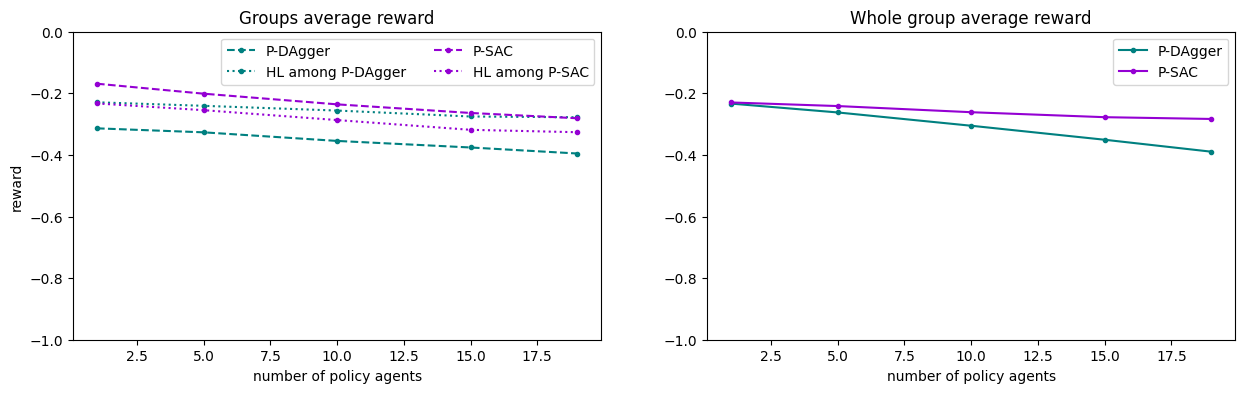

In [25]:
from matplotlib import pyplot as plt

_, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))

for name, ds in data.groupby('policy'):
    ps = ds[ds.group=='policy']
    hs = ds[ds.group=='HL']
    num = np.asarray(ps.number)
    ax1.plot(ps.number, ps.reward, '.--', color=colors[name], label=name)
    ax1.plot(hs.number, hs.reward, '.:', color=colors[name], label=f'HL among {name}')
    total = (num * np.asarray(ps.reward) + (20 - num) * np.asarray(hs.reward)) / 20 
    ax2.plot(ps.number, total, '.-', color=colors[name], label=name)
ax1.legend(ncols=2)
ax2.legend(ncols=1)
ax1.set_xlabel('number of policy agents')
ax1.set_ylim(-1, 0)
ax2.set_xlabel('number of policy agents')
ax2.set_ylim(-1, 0)
ax1.set_ylabel('reward')
ax1.set_title('Groups average reward');
ax2.set_title('Whole group average reward');

We observe that the whole group performance is decreases far less compared to the policies trained in the single-agent environment. `P-SAC` agents have higher rewards than `HL` while `P-Dagger` agents lower rewards. Interestingly, `HL` agents seem to be almost not impacted by the number of `P-Dagger` agents, while more `P-SAC` agents decreases the performance of `HL` agents, althought not by much.

The histograms below tells a similar story:
- SAC move straight but with lots of safety violations (the -2 rewards)
- BC agents are stuck togeter for about 50% of the time
- DAgger agents have less outlier (less violations/collisions) and their number not impact the rewards distribution as much as the others.

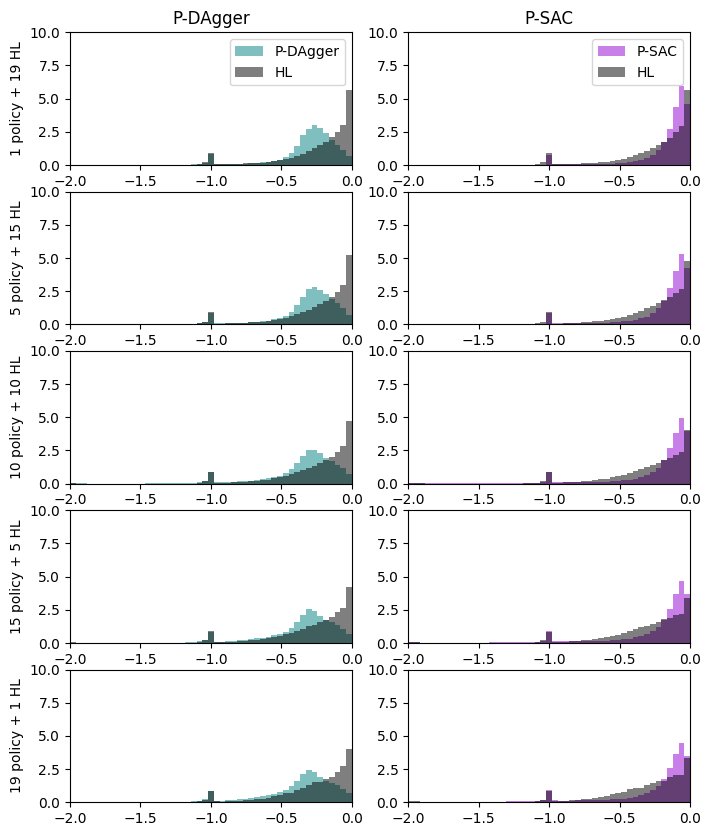

In [26]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(8, 10))

i = 0
for cols, number in zip(axs, ns):
    bins = np.linspace(-2, 0, 50)
    for ax, name in zip(cols, models):
        if name == 'P-DAgger':
            ax.set_ylabel(f"{number} policy + {20 - number} HL", rotation=90)
        ax.hist(rewards[i].flatten(), density=True, 
                color=colors[name], alpha=0.5, bins=bins, label=name)
        i += 1
        ax.hist(rewards[i].flatten(), density=True, 
                color='black', alpha=0.5, bins=bins, label="HL")
        ax.set_xlim(-2, 0)
        ax.set_ylim(0, 10)
        i += 1
        if number == 1:
            ax.set_title(name)
            ax.legend()

## Final video

One final video where for fun we let the all policies (but `P-BC`) we have trained play togeher.

In [48]:
from navground.learning.evaluation import InitPolicyBehavior
from navground.sim.ui.video import display_video_from_run

colors = {
    'BC': 'red',
    'DAgger': 'green',
    'SAC': 'blue', 
    'P-DAgger': 'teal',
    'P-SAC': 'darkviolet'
}

groups = [
    GroupConfig(indices=slice(4 * i, 4 * (i + 1)), 
                policy=f"{name}/policy.onnx",
                color=color)
    for i, (name, color) in enumerate(colors.items())
]

exp = make_experiment_with_env(ma_env, groups=groups, record_reward=False)
exp.steps = 1800
exp.record_config.pose = True
run = exp.run_once(seed=123)
display_video_from_run(run, factor=10, width=400, display_width=400)